# 시작하기 전에

---

현재까지 배운 내용으로는 분류와 회귀에 대한 경험을 하였고 전처리와 특성을 조정하는 단계까지 학습하였다.

이번에는 정확한 분류보다 샘플 데이터가 어떤 쪽에 더 가까운지 확률을 나타내주는 로지스틱 회귀에 대해서 알아볼 예정이다.

# k-최근접 알고리즘 적용 확률 구하기

##데이터 준비하기

In [2]:
import pandas as pd
import numpy as np

fish = pd.read_csv("https://bit.ly/fish_csv_data")

fish.head(3)

# fish 데이터에서 Species 종류 확인하기

pd.unique(fish['Species'])


#Species column을 target으로 저장하기

fish_target = fish[['Species']].to_numpy()


#나머지 column을 fish_input으로 저장하기

# fish.info()

fish_input = fish[['Weight', 'Length', 'Diagonal', 'Height', "Width"]].to_numpy()


fish_target = fish["Species"].to_numpy()

fish_target.shape

(159,)

## 데이터 나누기 / 정규화

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

train_input, test_input, train_target, test_target = train_test_split(fish_input, fish_target, random_state = 42)

ss = StandardScaler()

ss.fit(train_input)

train_scaled = ss.transform(train_input)
test_scaled  = ss.transform(test_input)


##KneighborsClassifier 적용하기

In [4]:
from sklearn.neighbors import KNeighborsClassifier

kn = KNeighborsClassifier()
kn.n_neighbors = 3

kn.fit(train_scaled, train_target)
print(kn.score(train_scaled, train_target), kn.score(test_scaled, test_target))

0.8907563025210085 0.85


## 다중분류

---

앞서 데이터프레임(fish)에서 Species가 7개였는데 fish_target은 fish['Species']를 통해 만들어서 train_taget, test_target에는 7개의 종류가 있다.

이렇게 타깃 데이터에 2개 이상의 클래스가 포함된 문제를 **다중 분류**
(multi-class classification) 라 부른다.



KNeighborsClassifier을 2장에서 사용했을 때는

target의 종류를 0과 1로 두고 이진 분류를 하였다. 다중 분류에서도 동일하게 target 값에 번호를 매겨서 사용할 수 있는데 사이킷런을 사용하면 문자열로 된 타깃값을 그대로 사용할 수 있다.

이때 주의할 점은 타깃값을 그대로 사이킷런 모델에 전달하면 순서가 자동으로 알파벳 순으로 매겨진다. 따라서 pd.unique(fish['Species'])로 출력했던 순서와 다르기 때문에 KNeighborsClassifier에서 정렬한 타깃값은 classes_속성에 저장되어 있다.

In [5]:
print(kn.classes_)

print(pd.unique(fish["Species"]))

['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']
['Bream' 'Roach' 'Whitefish' 'Parkki' 'Perch' 'Pike' 'Smelt']


위와 같이 결과가 다른 것을 확인할 수 있는데, Bream이 첫 번째 클래스, Parkki가 두 번째 클래스가 되는 식이다.

predict() 메서드는 친절하게도 타깃값으로 예측을 출력한다. 처음 5개 샘플의 타깃값을 예측해보자

In [6]:
print(kn.predict(test_scaled[:5]))

['Perch' 'Smelt' 'Pike' 'Perch' 'Perch']


위 5개의 샘플에 대한 예측에 대한 결과에 대해 알아보자

사이킷런의 분류 모델은 predict_proba() 메서드로 클래스별 확률값을 반환한다. 테스트 세트에 있는 처음 5개의 샘플에 대한 확률을 출력해보자. 넘파이 round() 함수는 기본으로 소수점 첫째 자리에서 반올림을 하는데, decimals 매개변수로 유지할 소수점 아래 자릿수를 지정할 수 있다.

In [7]:
import numpy as np

proba = kn.predict_proba(test_scaled[:5])

print(np.round(proba, decimals = 4))

[[0.     0.     1.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.    ]
 [0.     0.     0.     1.     0.     0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]]


위 결과는 모든 column에 대한 위에서 5개의 row의 확률을 나타내는데,
column은 kn.classes_에서 나타냈던 순서이고, 각각의 확률을 나타낸다.

계산한 모델이 가장 가까운 이웃의 비율이 맞는지 확인해 보자.

## kneighbors()

---
kneighbors를 통해서 가까운 훈련 데이터에서의 거리와 인덱스 위치를 알 수 있다.

따라서 4번째 테스트 샘플에서 가까운 샘플의 거리와 위치를 알고 싶다면


```
distances, indexes = kn.kneighbors(test_scaled[3, :])
```
위와 같이 나타내야할것 같지만 그렇게 되면 test_scaled에서 선택한 배열의 크기는 5, 로 1차원의 데이터가 된다. 따라서 앞서 배웠던 reshape를 활용하여

```
n_target = test_scaled[3, :]

n_target = n_target.reshape(-1, 1)
```
위와 같이 코드를 작성하면 어김없이 오류를 반환한다.

kn은 5개의 feature을 통해서 학습을 하였는데 n_target과 같이 reshape를 하면 1개의 column으로 쭉 나오기 때문에 feature이 하나로 인식한다.

따라서

```
n_target = test_scaled[3, :]

n_target = n_target.reshape(1, -1)
```

와 같이 작성하면 하나의 row를 가진 여러개의 column으로 나오게 된다.

또는, 넘파이의 슬라이싱 연산자를 사용해도 되는데 슬라이싱 연산자는 하나의 샘플만 선택해도 항상 2차원 배열이 만들어지기 때문이다.

```
distances, indexes = kn.kneighbors(test_scaled[3:4])

```

In [8]:
n_target = test_scaled[3:4, :]

print(n_target.shape)

n_target = n_target.reshape(1, -1)

print(n_target.shape)

distances, indexes = kn.kneighbors(n_target)

print(train_target[indexes])
print(kn.classes_)

(1, 5)
(1, 5)
[['Roach' 'Perch' 'Perch']]
['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']


앞선 predict_proba를 사용해서 확률을 확인하였고, kn.kneighbors를 통해서
검증을 하였다.

predict_proba(test_sclaled[:5]를 사용하여 5개 샘플의 확률을 확인하였을 때,

4번째 샘플의 확률은 Perch : 66.67%, Roach : 33.33% 이였다.

가장 가까운 3개의 데이터를 distances, indexes = kn.kneighbors를 통해서 4번째 샘플과 가장 가까운 3개의 데이터를 확인하였을 때 Roach가 1개, Perch가 2개로
클래스의 확률을 예측할 수 있었다.

## KNeighborsClassifier의 한계

---

KNeighborsClassifier을 통해서 최근접 이웃 분류 알고리즘 모델을 구현하였다.

이웃의 수가 많아지면 제대로 된 예측이 힘들어지기 때문에 n_neighbors를 3으로 설정하였는데 그 때문에 확률이 0/3, 1/3, 2/3, 3/3이 전부가 된다.

# 로지스틱 회귀(Logistic regression)

---

로지스틱 회귀는 이름은 회귀이지만 분류모델이다. 이 알고리즘은 선형 회귀와 동일하게 선형 방정식을 학습한다. 예를 들면 다음과 같다.

$$z = a * (Weight) + b * (Length) + c * (Diagonal) + d * (Height) + e *(Width) + f $$

여기에서 a, b, c, d는 가중치 혹은 계수이다. 앞서 다룬 다중 회귀를 위한 선형 방정식과 같다. z는 어떠한 값도 가능하다. 하지만 확률이 되려면 결과값이 자연수이면서 0 ~ 1(or 0 ~ 100%) 사이의 값이 되어야 한다.

시그모이드 힘수(sigmoid function)/ 로지스틱 함수(logistic function)를 사용하면
z가 아주 큰 음수일 때는 0이 되고, 아주 큰 양수일 때는 1이 되도록 바꿀 수 있다.


---
시그모이드 함수의 식은 다음과 같다.

$$ Φ = \frac{1}{1+e^{-z}} $$

위의 선형 방정식에서 z값은 시그모이드 함수에서의 z값이다.

시그모이드 함수는 z값이 양의 무한대에 가깝다면, 1/1 꼴로 되어서 1에 가까워지고

z값이 음의 무한대에 가깝다면, 분모가 너무 커져서 0에 가까워진다.

##시그모이드 함수 시각화

---

위의 시그모이드 함수를 참고하였을 때 z값이 어떤 값이 되더라도 함수의 결과는 절대로 0과 1사이에서 나타나는 것을 알 수 있다. 따라서 0 ~ 1사이의 값을

0~100%까지 확률로 해석할 수 있다!

-5와 5 사이에 0.1간격으로 배열 z를 만든 다음 z 위치마다 시그모이드 함수를 계산한다. 지수 함수 계산은 np.exp()를 이용한다.

-5부터 5까지의 배열을 0.1간격으로 만드는데 소수점 단위의 step은 일반 python 문법에서 지원하지 않으므로 numpy를 사용한다.

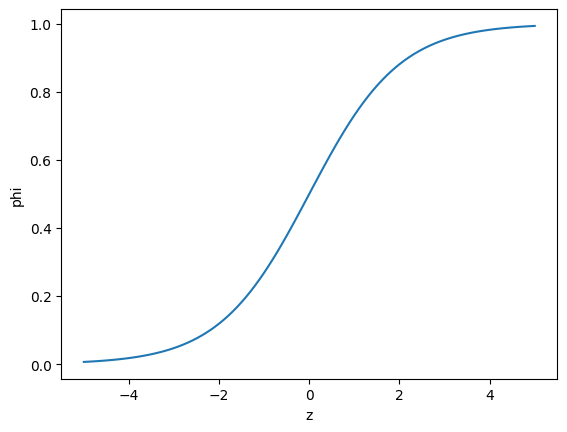

In [9]:
import numpy as np
import matplotlib.pyplot as plt


# 일반 for문을 사용하여 배열 만들기
a = [i for i in range(-5, 6, 1)]
a

# numpy를 사용하여 소수점 단위의 z배열 만들기
z = np.arange(-5, 5.1, 0.1)

# phi(시그모이드 함수 결과) 선언
phi = 1 / (1 + np.exp(-z))

plt.plot(z, phi)
plt.xlabel("z")
plt.ylabel("phi")
plt.show()

# 로지스틱 회귀로 이진 분류 수행

---

numpy array는 True, False 값을 전달하여 행을 선택할 수 있다. 이를 불리안 인덱싱(Boolean indexing)이라 하는데 예시는 다음과 같다.

```
char_array = np.array(['a', 'b', 'c', 'd', 'e'])
print(char_array[[True, False, True, False, False]])
```

위와 같이 코드를 작성하면 결과값은 True인 a와 c가 출력된다.

같은 방식을 사용하여서 도미와 빙어의 행만 골라낼 수 있다.
비교 연산자를 이용하는데 도미와 빙어의 행을 모두 True로 만든다.

예시는 다음과 같다.

```
bream_smelt_indexes = (train_target == 'Bream') | (train_target == 'Smelt')
```

In [10]:
# 비교 연산자 or을 사용하여 Bream과 Smelt만 True로 만드는 배열 생성

bream_smelt_indexes = (train_target == 'Bream') | (train_target == 'Smelt')

# 불리언 인덱싱을 통하여 True만 train_bream_smelt에 입력

train_bream_smelt = train_scaled[bream_smelt_indexes]
target_bream_smelt = train_target[bream_smelt_indexes]

In [11]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(train_bream_smelt, target_bream_smelt)

print(target_bream_smelt[:5])

print(lr.predict(train_bream_smelt[:5]))

['Bream' 'Smelt' 'Bream' 'Bream' 'Bream']
['Bream' 'Smelt' 'Bream' 'Bream' 'Bream']


위와 같이 분류 예측에 성공하였다. 하지만 확룔이 0 ~ 1 안에서의 확률로 나오는지 역시 중요한데

KNeighborsClassifier클래스와 같이 predict_proba() 메소드를 통해서 확률을 확인할 수 있다.

lr.classes_롤 통해서 column의 순서를 확인하고 그에 맞는 확률을 확인한다.

In [12]:
proba = lr.predict_proba(train_bream_smelt[: 5])

print(lr.classes_)

print(np.round(proba, decimals = 4))

['Bream' 'Smelt']
[[0.9976 0.0024]
 [0.0274 0.9726]
 [0.9949 0.0051]
 [0.9858 0.0142]
 [0.9977 0.0023]]


위 결과를 통해서 각 분류 결과에 대한 확률을 0 ~ 1사이의 결과를 통해서 알 수 있었다.

## 이진분류 선형 방정식 확인하기

---
Logistic Regression 클래스는 linear_model 패키지에 있는 만큼 계수와 절편을 확인할 수 있다.

(lr.coef_와 lr.intercept_)를 통해서 계수, 절편을 확인하고 선형 방정식을 추측 가능하다.

In [13]:
print(lr.coef_, lr.intercept_)

fish.columns

[[-0.4037798  -0.57620209 -0.66280298 -1.01290277 -0.73168947]] [-2.16155132]


Index(['Species', 'Weight', 'Length', 'Diagonal', 'Height', 'Width'], dtype='object')

계수와 특성을 통해서 확인할 수 있는 방정식은 다음과 같다.

$$z = (-0.404 * Weight) + (-0.576 * Length) + (-0.663 * Diagonal) + (-1.013 * Height) + (-0.732 * Width) -2.162 $$

로지스틱 회귀는 선형 회귀와 매우 비슷하지만 분류모델이라는 차이가 존재한다.

LogisticRegression 모델로 z값을 계산할 수 있는데 decision_function() 메서드를 통해서 z값을 출력 가능하다.

In [14]:
# train_bream_smelt의 처음 5개 샘플의 z값 출력

print(lr.decision_function(train_bream_smelt[:5]))

[-6.02927744  3.57123907 -5.26568906 -4.24321775 -6.0607117 ]


decision_function을 통해서 얻은 z값을 시그모이드 함수에 넣으면 확률을 얻을 수 있다.

python의 사이파이 scipy 라이브러리에도 시그모이드 함수가 있는데 바로 expit()이다. np.exp() 함수를 사용해 분수 계산을 하는 것보다 훨씬 편리하고 안전하다.

In [15]:
# 기존의 np.exp 방식 사용하기
import numpy as np

decision = lr.decision_function(train_bream_smelt[:5])

phi = 1 / (1 + np.exp(-decision))
print(phi)

phi = [1 / (1 + np.exp(-i)) for i in decision]
print(phi)


[0.00240145 0.97264817 0.00513928 0.01415798 0.00232731]
[0.0024014518780479588, 0.9726481722467774, 0.005139283545591804, 0.014157979296024114, 0.0023273110833360536]


진짜 numpy 배열은 리스트 내포도 필요없고 for문도 필요없고 그냥 배열 내에서 각각의 원소에 계산을 해주는게 신기하다.

In [16]:
# scipy 방식 이용하기
from scipy.special import expit

decision = lr.decision_function(train_bream_smelt[:5])

print(expit(decision))

[0.00240145 0.97264817 0.00513928 0.01415798 0.00232731]


위 결과는 그냥 어이가 없다. 코드가 말도 안되게 줄어든다..

아무튼 위 결과들을 통해서 predict_proba() 메서드에서 두번째 열, 즉 양성 클래스에 대한 z값을 반환한다.

# 로지스틱 회귀로 다중 분류 수행

---

Linear Regression과 같이 이중 분류와 다중 분류는 과정에서 큰 차이는 나지 않는다.

LogisticRegression 클래스는 기본적으로 반복적인 알고리즘을 사용한다. Lasso Regression을 했을 때와 비슷하게 max_iter 매개변수를 조정하여 훈련 반복 횟수를 정할 수 있다.

default는 100회인데, 준비한 데이터셋을 사용해 모델을 훈련하면 반복 횟수가 부족하다는 경고가 발생하므로, 1000회로 조절하여 진정한다.

또한 LogisticRegression은 기본적으로 Ridge Regression과 같이 계수의 제곱을 규제한다. 이런 규제를 ***L2규제***라 한다. Ridge 에서는 alpha를 통해서 규제의 양을 조절하였다.

LogisticRegression은 매개변수 C를 통해서 규제를 조절할 수 있는데
alpha와의 다른점은 alpha는 클수록 규제가 커지고, C는 작을수록 규제가 커진다.

C의 default는 1인데, 이번 학습에서는 규제를 조금 완화하기 위해서 20으로 늘리고 진행한다.

LogisticRegression 클래스를 사용해서 다중 분류를 통해 이중 분류와의 차이를 알아보자



In [17]:
# 클래스를 이용한 객체 선언 및 매개변수 조정
lr = LogisticRegression(C = 20, max_iter = 1000)

lr.fit(train_scaled, train_target)
print(lr.score(train_scaled, train_target), lr.score(test_scaled, test_target))

0.9327731092436975 0.925


훈련 세트의 점수가 더 높으면서 두 점수의 큰 차이 없이 높아서 과대적합이나 과소적합은 나타나지 않은것 같다.

훈련 세트에서 처음 5개에 대한 예측을 진행한다.

In [18]:
# 처음 5개 샘플의 target
print(train_target[:5])

# 처음 5개 샘플의 target predict 값
print(lr.predict(train_scaled[:5]))


['Bream' 'Pike' 'Smelt' 'Perch' 'Parkki']
['Bream' 'Pike' 'Smelt' 'Perch' 'Parkki']


이제 predict_proba() 메서드를 통해서 확률을 구한다.

In [19]:
proba = lr.predict_proba(train_scaled[ : 5])
print(lr.classes_)
print(np.round(proba, decimals = 3))

['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']
[[0.998 0.001 0.    0.    0.    0.    0.002]
 [0.    0.    0.001 0.999 0.    0.    0.   ]
 [0.    0.002 0.051 0.    0.006 0.941 0.   ]
 [0.    0.001 0.86  0.001 0.135 0.    0.004]
 [0.009 0.783 0.007 0.    0.187 0.    0.014]]


위를 통해서 각 column에 대한 proba를 확인할 수 있다.

순서는 lr.classes_를 통해서 확인할 수 있다.

## 다중분류 선형 방정식 확인하기

---

이진분류의 선형 방정식을 확인하였을 때와 같이 coefficient와 intercept를 확인할 수 있다.

In [20]:
print(lr.coef_.shape, lr.intercept_.shape)

(7, 5) (7,)


한 행에 coefficient가 나오는데 7개의 행이 존재한다. 또한 절편역시 7개가 존재하는데 이를 통해서 7개의 z값을 계산한다는 사실을 알 수 있다.

다중 분류는 클래스마다 z값을 하나씩 계산하는데, 가장 높은 z값을 출력하는 클래스가 예측 클래스가 된다.

이진 분류에서는 시그모이드 함수를 사용해서 z를 0 ~ 1사이의 값으로 변환하였다. 다중 분류는 이와 달리 소프트맥스(softmax) 함수를 사용하여 7개의 z 값을 확률로 변환 한다.

## softmax function

---

sigmoid function / logistic function 은 하나의 선형 방정식의 출력값을 0 ~ 1사이로 압축하는데 이와 달리 softmax function은 여러 개의 선형 방정식의 출력값을 0 ~ 1 사이로 압축하고 전체 합이 1이 되도록 만든다. 이를 위해 지수 함수를 사용하기 때문에 정규화된 지수 함수라고도 부른다.

### softmax function 계산식

---

소프트맥스의 계산 벙식은 먼저 7개의 z값을 z1 ~ z7이라 나타내고 z1 ~ z7까지 값을 사용해서 시그모이드 함수의 exp(-z)를 계산해서 모두 더하고 이를 e_sum이라고 하자.

$$e\_sum = \sum^n_{i=1}(e^{-z_i}) $$

그 다음 각각을 e_sum으로 나눠주면 된다.

$$S_1 = \frac{e^{z1}}{e\_sum},\;S_2 = \frac{e^{z2}}{e\_sum}..., S_7 = \frac{e^{z7}}{e\_sum} $$

S1부터 S7까지를 모두 더하면 분자와 분모가 같아지므로 1이된다.



### 시그모이드와 소프트맥스

---

두 함수는 사이킷런에서 자동으로 계산해주기 때문에 크게 신경쓰지 않아도 된다고 생각할 수 있지만, 나중에 신경망을 배울 때 또 등장하기 때문에 잘 알아두는 것이 좋다.

### softmax 계산 적용하기

---

이진분류때와 마찬가지로 z1부터 z7까지의 값을 구한다면 softmax 함수를 통해서 확률로 바꾸어보자

In [36]:
# 테스트 세트의 처음 5개 샘플에 대한 z값 구하기

decision = lr.decision_function(test_scaled[ : 5])

print(np.round(decision, decimals = 2))
decision.shape

[[ -6.5    1.03   5.16  -2.73   3.34   0.33  -0.63]
 [-10.86   1.93   4.77  -2.4    2.98   7.84  -4.26]
 [ -4.34  -6.23   3.17   6.49   2.36   2.42  -3.87]
 [ -0.68   0.45   2.65  -1.19   3.26  -5.75   1.26]
 [ -6.4   -1.99   5.82  -0.11   3.5   -0.11  -0.71]]


(5, 7)

하나의 샘플마다 7개의 z값이 나온것을 확인할 수 있다.

In [54]:
# 기존의 계산을 이용하는 경우 (keepdims = False)

test = np.sum(np.exp(decision), axis = 1)
test = test.reshape(5, -1)

print(test.shape)
pp = np.exp(decision) / test
print(np.round(pp, decimals = 3))


# 기존의 계산을 이용하는 경우 (keepdims = True)

proba = np.exp(decision) / np.sum(np.exp(decision), axis = 1, keepdims = True)

print(np.round(proba, decimals = 3))

(5, 1)


array([[0.000007, 0.013511, 0.841284, 0.000314, 0.13566 , 0.006671,
        0.002552],
       [0.      , 0.002556, 0.043908, 0.000034, 0.007309, 0.946188,
        0.000005],
       [0.000019, 0.000003, 0.034057, 0.934811, 0.015047, 0.016034,
        0.00003 ],
       [0.010932, 0.03405 , 0.305541, 0.006609, 0.566581, 0.000069,
        0.076219],
       [0.000004, 0.000367, 0.904006, 0.002413, 0.089471, 0.00241 ,
        0.001329]])

keepdims는 차원을 맞춰주는 매개변수인데, True를 하지 않을 경우에는 따로 reshape를 통해서 차원을 맞추고  진행하여야 한다.

그런데 진짜 이런 터무니 없는 계산도 되는게 신기할 따름...


In [51]:
# scipy.special 패키지의 softmax를 사용하는 경우

from scipy.special import softmax

proba = softmax(decision, axis = 1)

print(np.round(proba, decimals = 3))

[[0.    0.014 0.841 0.    0.136 0.007 0.003]
 [0.    0.003 0.044 0.    0.007 0.946 0.   ]
 [0.    0.    0.034 0.935 0.015 0.016 0.   ]
 [0.011 0.034 0.306 0.007 0.567 0.    0.076]
 [0.    0.    0.904 0.002 0.089 0.002 0.001]]


동일한 결과가 나온것을 확인할 수 있다.

axis를 설정하는 것이 중요한데, 0인 경우에는 column단위의 계산을 진행하고, 1인 경우에는 row 단위의 계산을 진행하기 때문에 계산이 아예 달라질 수 있다.

# 고찰

---

이번 학습은 데이터를 pandas를 통해서 불러오고, 특정 열을 numpy배열로 바꾸는 과정을 진행하였다.

데이터를 numpy 배열로 변환한 다음 StandardScaler를 통해서 scale을 지정하였다.

처음에는 KNeighborsClassifier 클래스를 통해서 다중 분류를 진행하였고, predict_proba() 메서드를 통해서 확률을 확인할 수 있었다.

그러나 최근접 알고리즘 분류 모델의 경우에는 이웃의 갯수에 따라서 확률이 정해지는데 이웃의 갯수를 늘리면 정확도가 떨어지고 줄이면 확률의 갯수 역시 줄어들기 때문에 확률을 나타내는 모델로는 한계가 나타났다.

확률을 나타내는데 더 좋은 모델로는 로지스틱 회귀가 있었다.

로지스틱 회귀는 회귀지만 분류모델이다.

이진 분류의 경우에는 타겟데이터를 비교 연산자를 통해서 두 column만 True로 불리안
선형 방정식을 통해서 나온 z값을 시그모이드 함수에 넣어서 나오는 phi값을 반환하였고, 역시 predict_proba()메서드를 통해서 확률을 확인할 수 있었다.

다중 분류의 경우에는 모든 데이터를 학습시켰는데 이 과정에서 max_iter와 C값을 조정하여 학습 횟수와 규제의 정도를 조절할 수 있었다.

이번 모델의 경우에는 7개의 클래스를 분류하였는데, 하나의 클래스마다 하나의 z값 계산해서 가장 높은 z값을 출력하는 클래스가 예측 클래스가 되었다.

이진 분류의 경우에는 시그모이드 함수를 통해서 확률을 계산하였는데, 다중 분류의 경우에는 소프트맥스 함수를 통해서 결과를 도출하였다. z값을 지수로 가지는 지수 함수를 지수함수의 총 합으로 나누는 방식으로 확률을 구하였다.

다중 분류의 경우에는 전체 클래스에 대한 합이 항상 1이 되도록 만든다면, 0 ~ 1사이의 값을 확률로 해석할 수 있다.